# Salary Prediction from LinkedIn Job Postings - Analyze Job Titles

## Setup

In [11]:
import pandas as pd, numpy as np
import salary
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

## Read Data

In [3]:
df_jobs = pd.read_csv('data/jobs.csv')

In [4]:
df_jobs

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,med_salary,min_salary,...,compensation_type,normalized_salary,zip_code,company_description,company_state,company_country,company_city,company_zip_code,company_industries,company_employee_count
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,NaN,17.0,...,BASE_SALARY,38480.0,8540.0,With years of experience helping local buyers ...,NJ,US,Jersey City,07302,Real Estate,402.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,NaN,30.0,...,BASE_SALARY,83200.0,80521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,NaN,45000.0,...,BASE_SALARY,55000.0,45202.0,"In April of 1983, The National Exemplar began ...",Ohio,US,Mariemont,45227,Restaurants,15.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,NaN,140000.0,...,BASE_SALARY,157500.0,11040.0,"Abrams Fensterman, LLP is a full-service law f...",New York,US,Lake Success,11042,Law Practice,222.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,NaN,60000.0,...,BASE_SALARY,70000.0,52601.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,NaN,120000.0,...,BASE_SALARY,157500.0,94595.0,"For more than 30 years, Lozano Smith has serve...",California,US,Fresno,93720,Law Practice,185.0
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,NaN,NaN,...,NaN,NaN,NaN,Pinterest's mission is to bring everyone the i...,California,US,San Francisco,0,Software Development,8667.0
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,NaN,NaN,...,NaN,NaN,99201.0,EPS Learning has partnered with educators for ...,MD,US,Bethesda,20814,Education Administration Programs,127.0
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States",2793699.0,NaN,NaN,...,NaN,NaN,NaN,Trelleborg Applied Technologies manufactures a...,Lancashire,GB,Rochdale,OL11 1TQ,Industrial Machinery Manufacturing,47.0


In [5]:
# We isolate only job titles
df_jobs = df_jobs[['job_id', 'title']]
df_jobs

,job_id,title
0,921716,Marketing Coordinator
1,1829192,Mental Health Therapist/Counselor
2,10998357,Assitant Restaurant Manager
3,23221523,Senior Elder Law / Trusts and Estates Associat...
4,35982263,Service Technician
...,...,...
123844,3906267117,Title IX/Investigations Attorney
123845,3906267126,"Staff Software Engineer, ML Serving Platform"
123846,3906267131,"Account Executive, Oregon/Washington"
123847,3906267195,Business Development Manager


## Understand Job Titles

In [6]:
df_jobs['title'].value_counts()

title
Sales Manager                                       673
Customer Service Representative                     373
Project Manager                                     354
Administrative Assistant                            254
Senior Accountant                                   238
                                                   ... 
Cath Lab / IR Technologist (Cert) - Cardiac Cath      1
Energy Administrative Assistant Part Time             1
ASSOCIATE CLIENT SUCCESS MANAGER                      1
Student Nurse - Telemetry                             1
Marketing Social Media Specialist                     1
Name: count, Length: 72521, dtype: int64

In [7]:
# Example of job titles that should belong to the same norm title
df_jobs['title'].value_counts().filter(like='Software Engineer')

title
Software Engineer                                                     181
Senior Software Engineer                                              162
Embedded Software Engineer                                             30
Lead Software Engineer                                                 20
Software Engineer in Test                                              20
                                                                     ... 
LabVIEW Software Engineer                                               1
AI ML Software Engineer - Artificial Integence / Machine Learning       1
Lead Software Engineer, Application Support                             1
Staff Software Engineer - Big Data                                      1
Angular Software Engineer                                               1
Name: count, Length: 730, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

,count,%
count,,
=1,60922,84.006012
=2,6023,8.305181
=3,1884,2.597868
=4,1031,1.421657
>10,928,1.279629
=5,590,0.813557
=6,370,0.510197
=7,278,0.383337
=8,195,0.268888


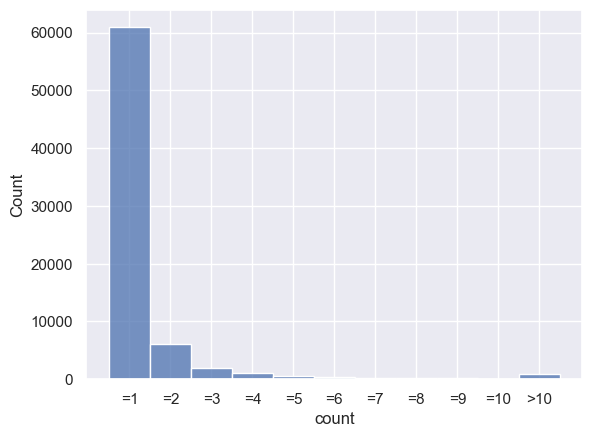

In [8]:
'''
Are there a lot of job titles with very low counts?
Yes - 84.0% of job titles appear only once, 8.31% appear twice, and 2.60% appear three times.
Let's decide that job titles that appear at least 5 times are normalized.
'''
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
labels = ['=1', '=2', '=3', '=4', '=5', '=6', '=7', '=8', '=9', '=10', '>10']
counts = pd.cut(df_jobs['title'].value_counts(), bins=bins, labels=labels)
display(sns.histplot(counts))
pd.concat([counts.value_counts(),counts.value_counts(normalize=True)*100], keys=['count', '%'], axis=1)


## Normalize Job Titles with Sentence BERT Encodings

In [9]:
# How we evaluate: We do an eye test on a sample of 100 normalized job titles of count < 10
counts = df_jobs['title'].value_counts()
val_titles = list(counts[counts < 10].sample(100, random_state=42).index)
val_titles

['Partner Marketing Specialist',
 'A&P Technician',
 'Chassis Lead Engineer [5449]',
 'Fleet Mechanic',
 'International Financial Controller',
 'Research Data Analyst',
 'Manager Account Management',
 'Creative Lead, Presentation Design',
 'Signing Agent - Palm Springs, California',
 'Legal Coordinator',
 'Nurse Manager - Emergency Room',
 'Registered Nurse - Effingham',
 'Urgent Care Technician Training Program – Apply Today!',
 'Epicor Developer',
 '2024-2025 GENERAL RESOURCE TEACHER - SILVESTRI JHS',
 'Vice President of Asset & Property Management',
 'Media Coordinator',
 'Senior Director, Local Performance Marketing',
 'Travel RRT - Job Id: JO03716440',
 'Senior Corporate Counsel, M&A',
 'Client Director',
 'Certified Nursing Assistant - Behavioral Health',
 'Radio Frequency Millimeter-Wave Engineer IV',
 'Registered Nurse Pediatric Homecare',
 'Associate, Corporate Development',
 'Travel Nurse RN - ICU/Critical Care - $2,436 per week in Perth Amboy, NJ',
 'Manufacturing Associate 

In [ ]:
class TitleNormModel:
    def __init__(self, norm_titles: list[str]):
        self.sent_transformer = salary.SentenceBertEncoder()
        self.norm_titles = norm_titles
        self.norm_title_embeddings = self.sent_transformer.encode(norm_titles)
    
    def normalize(self, titles: list[str]):
        title_embeddings = self.sent_transformer.encode(titles)
        similarities = self.sent_transformer.similarity(title_embeddings, self.norm_title_embeddings)
        idxs = similarities.argmax(1)
        return np.array(self.norm_titles)[idxs]

In [10]:
def get_norm_titles(min_count: int):
    return list(df_jobs['title'].value_counts()[df_jobs['title'].value_counts() >= min_count].index)

def print_validation_title_mapping(model: TitleNormModel):
    val_title_mapping = { val_title: norm_title for (val_title, norm_title) in zip(val_titles, model.normalize(val_titles)) }
    print("Validation title mapping:")
    print("----------------------------")
    for title, norm_title in val_title_mapping.items():
        print(f"{title} -> {norm_title}")

In [ ]:
# Eye-balling the mappings on accuracy, we believe that the mappings with min job title count threshold of 10 would be the best
norm_titles = get_norm_titles(10)
print('Number of norm titles', len(norm_titles))
model_10 = TitleNormModel(norm_titles)
print_validation_title_mapping(model_10)

Number of norm titles 1051
Validation title mapping:
----------------------------
Partner Marketing Specialist -> Marketing Specialist
A&P Technician -> Auto Body Technician
Chassis Lead Engineer [5449] -> Principal Engineer
Fleet Mechanic -> Mechanic
International Financial Controller -> Financial Controller
Research Data Analyst -> Data Analyst
Manager Account Management -> Account Manager
Creative Lead, Presentation Design -> Instructional Designer
Signing Agent - Palm Springs, California -> Financial Contract Analyst – Overland Park KS
Legal Coordinator -> Legal Secretary
Nurse Manager - Emergency Room -> Nursing Manager
Registered Nurse - Effingham -> Registered Nurse
Urgent Care Technician Training Program – Apply Today! -> Patient Care Technician
Epicor Developer -> Developer
2024-2025 GENERAL RESOURCE TEACHER - SILVESTRI JHS -> TEACHER-SCIENCE
Vice President of Asset & Property Management -> Vice President of Business Development
Media Coordinator -> Communications Manager
Seni

In [13]:
# We normalize job titles of jobs_clean.csv with this best model.
jobs_clean = pd.read_csv('data/jobs_clean.csv')
jobs_clean

,job_id,title,location,location_state,description,formatted_work_type,formatted_experience_level,remote_allowed,company_industries,company_country,company_state,company_city,company_description,company_employee_count,normalized_salary,normalized_salary_log10,min_salary,max_salary,med_salary,pay_period
0,921716,Marketing Coordinator,"Princeton, NJ",NJ,Job descriptionA leading real estate firm in N...,Full-time,Unknown,0.0,Real Estate,US,NJ,Jersey City,With years of experience helping local buyers ...,402.0,38480.0,4.585235,17.0,20.0,NaN,HOURLY
1,1829192,Mental Health Therapist/Counselor,"Fort Collins, CO",CO,"At Aspen Therapy and Wellness , we are committ...",Full-time,Unknown,0.0,NaN,Unknown,Unknown,Unknown,NaN,NaN,83200.0,4.920123,30.0,50.0,NaN,HOURLY
2,10998357,Assitant Restaurant Manager,"Cincinnati, OH",OH,The National Exemplar is accepting application...,Full-time,Unknown,0.0,Restaurants,US,Ohio,Mariemont,"In April of 1983, The National Exemplar began ...",15.0,55000.0,4.740363,45000.0,65000.0,NaN,YEARLY
3,23221523,Senior Elder Law / Trusts and Estates Associat...,"New Hyde Park, NY",NY,Senior Associate Attorney - Elder Law / Trusts...,Full-time,Unknown,0.0,Law Practice,US,New York,Lake Success,"Abrams Fensterman, LLP is a full-service law f...",222.0,157500.0,5.197281,140000.0,175000.0,NaN,YEARLY
4,35982263,Service Technician,"Burlington, IA",IA,Looking for HVAC service tech with experience ...,Full-time,Unknown,0.0,NaN,Unknown,Unknown,Unknown,NaN,NaN,70000.0,4.845098,60000.0,80000.0,NaN,YEARLY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,3906265414,Contract Administrator,"Irvine, CA",CA,"Position: Clinical Contracts Analyst, Req#: 63...",Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,MA,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,35.0,45.0,NaN,HOURLY
34853,3906266165,Catering Event Manager,Greater Indianapolis,Unknown,This role handles all the onsite catering and ...,Part-time,Associate,0.0,Staffing and Recruiting,US,Indiana,Indianapolis,Athena Recruiting provides recruitment service...,5.0,57500.0,4.759668,50000.0,65000.0,NaN,YEARLY
34854,3906266272,Quality Engineer,"Irvine, CA",CA,Position: Quality Engineer I (Complaint Invest...,Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,MA,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,30.0,50.0,NaN,HOURLY
34855,3906267117,Title IX/Investigations Attorney,"Walnut Creek, CA",CA,Our Walnut Creek office is currently seeking a...,Full-time,Mid-Senior level,0.0,Law Practice,US,California,Fresno,"For more than 30 years, Lozano Smith has serve...",185.0,157500.0,5.197281,120000.0,195000.0,NaN,YEARLY


In [16]:
jobs_clean['norm_title'] = model_10.normalize(list(jobs_clean['title']))
jobs_clean

,job_id,title,location,location_state,description,formatted_work_type,formatted_experience_level,remote_allowed,company_industries,company_country,...,company_city,company_description,company_employee_count,normalized_salary,normalized_salary_log10,min_salary,max_salary,med_salary,pay_period,norm_title
0,921716,Marketing Coordinator,"Princeton, NJ",NJ,Job descriptionA leading real estate firm in N...,Full-time,Unknown,0.0,Real Estate,US,...,Jersey City,With years of experience helping local buyers ...,402.0,38480.0,4.585235,17.0,20.0,NaN,HOURLY,Sales Manager
1,1829192,Mental Health Therapist/Counselor,"Fort Collins, CO",CO,"At Aspen Therapy and Wellness , we are committ...",Full-time,Unknown,0.0,NaN,Unknown,...,Unknown,NaN,NaN,83200.0,4.920123,30.0,50.0,NaN,HOURLY,Physical Therapist
2,10998357,Assitant Restaurant Manager,"Cincinnati, OH",OH,The National Exemplar is accepting application...,Full-time,Unknown,0.0,Restaurants,US,...,Mariemont,"In April of 1983, The National Exemplar began ...",15.0,55000.0,4.740363,45000.0,65000.0,NaN,YEARLY,ASSISTANT STORE MANAGER
3,23221523,Senior Elder Law / Trusts and Estates Associat...,"New Hyde Park, NY",NY,Senior Associate Attorney - Elder Law / Trusts...,Full-time,Unknown,0.0,Law Practice,US,...,Lake Success,"Abrams Fensterman, LLP is a full-service law f...",222.0,157500.0,5.197281,140000.0,175000.0,NaN,YEARLY,Associate Attorney
4,35982263,Service Technician,"Burlington, IA",IA,Looking for HVAC service tech with experience ...,Full-time,Unknown,0.0,NaN,Unknown,...,Unknown,NaN,NaN,70000.0,4.845098,60000.0,80000.0,NaN,YEARLY,Service Technician
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,3906265414,Contract Administrator,"Irvine, CA",CA,"Position: Clinical Contracts Analyst, Req#: 63...",Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,35.0,45.0,NaN,HOURLY,Operations Manager
34853,3906266165,Catering Event Manager,Greater Indianapolis,Unknown,This role handles all the onsite catering and ...,Part-time,Associate,0.0,Staffing and Recruiting,US,...,Indianapolis,Athena Recruiting provides recruitment service...,5.0,57500.0,4.759668,50000.0,65000.0,NaN,YEARLY,Sales Manager
34854,3906266272,Quality Engineer,"Irvine, CA",CA,Position: Quality Engineer I (Complaint Invest...,Contract,Mid-Senior level,0.0,Staffing and Recruiting,US,...,Natick,"Founded in 2002, TalentBurst is an MBE and JCC...",668.0,83200.0,4.920123,30.0,50.0,NaN,HOURLY,Quality Engineer
34855,3906267117,Title IX/Investigations Attorney,"Walnut Creek, CA",CA,Our Walnut Creek office is currently seeking a...,Full-time,Mid-Senior level,0.0,Law Practice,US,...,Fresno,"For more than 30 years, Lozano Smith has serve...",185.0,157500.0,5.197281,120000.0,195000.0,NaN,YEARLY,Associate Attorney


In [27]:
# Mesure the cardinality improvement after normalization
pd.DataFrame({
    'cardinality': [len(jobs_clean['title'].value_counts()), len(jobs_clean['norm_title'].value_counts())],
    'percentage (%)': [len(jobs_clean['title'].value_counts())/len(jobs_clean)*100, len(jobs_clean['norm_title'].value_counts())/len(jobs_clean)*100]
}, index=['title', 'norm_title']) 

,cardinality,percentage (%)
title,24137,69.245776
norm_title,62,0.177870


In [17]:
jobs_clean.to_csv('data/jobs_clean_nt.csv', index=False)

## Analyze PCA on Sentence BERT Encodings of Job Titles

In [14]:
sent_transformer = salary.SentenceBertEncoder()
title_embeddings = sent_transformer.encode(jobs_clean['title'])

In [24]:
pca = PCA() 
reduced_embeddings = pca.fit_transform(title_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

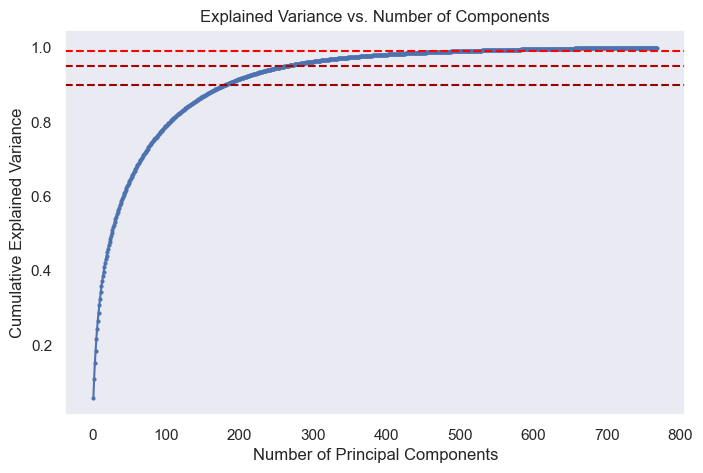

In [38]:

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', markersize=2)
plt.axhline(y=0.9, color='#900', linestyle='--')
plt.axhline(y=0.95, color='#A00', linestyle='--')
plt.axhline(y=0.99, color='#F00', linestyle='--')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()